# Prerequisites
conda install graphviz pygraphviz -c alubbock

Perform *dot -c* in conda prompt

# Content
This notebook displays the (Original) Collatz Tree, the Syracuse Tree (which only contains odd labeled nodes) and also pruned trees according to Kleinnijenhuis:
* https://arxiv.org/abs/2008.13643

Please note that this is a "quick & dirty" artifact for illustrative purpose only. For professional use. please use the comprehensive API provided by Christian Koch:
* https://github.com/c4ristian/collatz/tree/v1.3.2
* https://github.com/c4ristian/collatz/blob/v1.3.2/collatz/graph.py
* https://github.com/c4ristian/collatz/blob/v1.3.2/tests/test_graph.py
* https://github.com/c4ristian/collatz/blob/v1.3.2/notebooks/dutch_graph.md


In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from abc import ABC, abstractmethod

In [2]:
class Tree:
    def __init__(self, root):
        self.root = root
        self.labels = []
        self.prunable_nodes = []
        root.setTree(self)
        self.generate(root)

    @abstractmethod
    def generate(self, node):
        pass

    def addPrunable(self, node):
        self.prunable_nodes.append(node)
    
    def addLabel(self, label: int):
        self.labels.append(label)

    def shrinkRoot(self):
        self.root = self.root.successors[0]
        self.root.predecessor = None

    def prune(self):
        self.shrinkRoot()
        new_prunables = []
        for node in self.prunable_nodes:
            if node.predecessor is not None:
                if len(node.successors) > 1 and len(node.predecessor.successors) > 1:
                    node.predecessor.successors[1].successors.append(node.successors[1])
                    node.predecessor.successors[1].successors.reverse()
                    node.successors[1].predecessor = node.predecessor.successors[1]
                    node.successors[1].prunable = True
                    new_prunables.append(node.successors[1])
                node.predecessor.successors.remove(node)
                node.predecessor = None
        self.prunable_nodes = new_prunables
        return self

class Node:
    ORANGE = "#ffbe27"
    BLUE = "#c3d9ff"
    GREY = "#d3d3d3"

    def __init__(self, label, prunable=False):
        self.tree = None
        self.predecessor = None
        self.successors = []
        self.row = 0
        self.label = label
        self.prunable = prunable

    def addSuccessor(self, successor):
        successor.row = self.row + 1
        if self.tree is not None and not successor.label in self.tree.labels:
            successor.setTree(self.tree)
            successor.predecessor = self
            self.successors.append(successor)
    
    def setTree(self, tree: Tree):
        self.tree = tree
        self.tree.addLabel(self.label)
        if (self.prunable):
            self.tree.addPrunable(self)

class DataFrameGenerator:
    @staticmethod
    def generateGraphData(node : Node, horizontal_flip = False, predecessor_successor_array = []) -> list:
        successors = node.successors[::-1] if horizontal_flip else node.successors
        for successor in successors:
            predecessor_successor_array.append([node.label, successor.label, successor.prunable])
            DataFrameGenerator.generateGraphData(successor, horizontal_flip, predecessor_successor_array)
        return predecessor_successor_array

    @staticmethod
    def generateDataFrame(node : Node, horizontal_flip = False) -> pd.DataFrame: 
        columns = ['predecessorId', 'successorId', 'prunable']
        df = pd.DataFrame(columns = columns, data=DataFrameGenerator.generateGraphData(node, horizontal_flip, []))
        df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
        df[['predecessorId', 'successorId']] = df[['predecessorId', 'successorId']].astype('int')
        return df

In [3]:
def discrete_log(exp_start, factor, base=2, power=1, modulus=3):
    exp = exp_start
    while (res := factor * base**exp - 1):
        if res % 3 == 0:
            return exp
        else:
            exp += 1

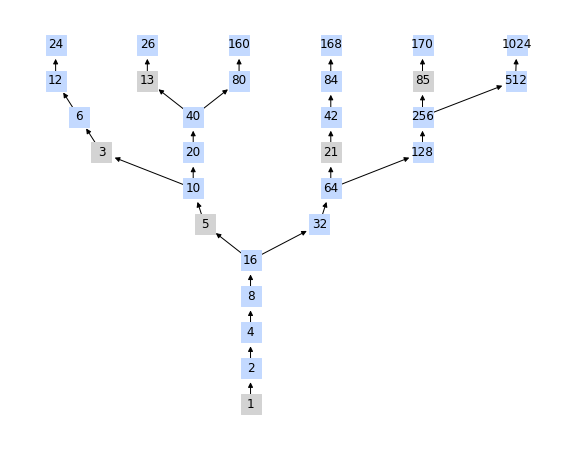

In [4]:
#Original Collatz Tree
class OriginalCollatzTree(Tree):
    def __init__(self, root: Node, height: int):
        self.height = height
        super().__init__(root)

    def generate(self, node: Node):
        if node.row < self.height:
            left_child = Node(node.label * 2)
            node.addSuccessor(left_child)
            if (node.label - 1) % 3 == 0 and node.predecessor != None and (node.predecessor.label - 1) % 3 > 0:
                right_child_label = (node.label - 1) / 3
                if right_child_label > 0:
                    right_child = Node(right_child_label)
                    node.addSuccessor(right_child)
                    self.generate(right_child)
            self.generate(left_child)

root = Node(1)
original_collatz_tree = OriginalCollatzTree(root, 10)

df = DataFrameGenerator.generateDataFrame(original_collatz_tree.root, True)
G = nx.from_pandas_edgelist(df, 'predecessorId', 'successorId', create_using=nx.DiGraph)
node_colors = []
for node in G:
    node_colors.append(Node.BLUE) if node % 2 == 0 else node_colors.append(Node.GREY)

pos = graphviz_layout(G, prog="dot", root=1, args='-Gsplines=true -Gsep=1 -Goverlap=false -Gorientation=10')
plt.figure(figsize=(10, 8))
plt.gca().invert_yaxis()
nx.draw(G, node_color=node_colors, pos=pos, with_labels=True,  node_shape="s", node_size=400, linewidths=1)
#nx.draw(G, node_color=node_colors, pos=pos, with_labels=True,  node_shape="s", bbox=dict(facecolor='skyblue', edgecolor='black', boxstyle='round,pad=0.2'))
#list(nx.selfloop_edges(G))

The Syracuse Tree results from deleting all even numbers from the the original Collatz Tree.

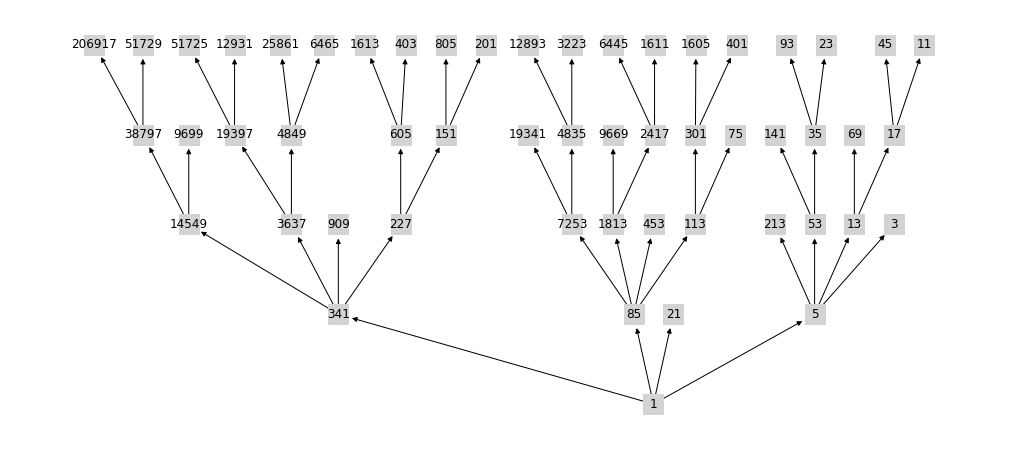

In [5]:
#Syracuse Tree
class SyracuseTree(Tree):
    def __init__(self, root: Node, height: int, children_per_row: int):
        self.height = height
        self.children_per_row = children_per_row
        super().__init__(root)

    def generate(self, node: Node):
        if node.row < self.height and node.label % 3 > 0:
            exp = 1
            for i in range(self.children_per_row[node.row]):
                exp = discrete_log(exp, node.label)
                child = Node((node.label * 2**exp - 1) / 3)
                node.addSuccessor(child)
                self.generate(child)
                exp += 1

root = Node(1)
syracuse_tree = SyracuseTree(root, 4, [5,4,2,2])

df = DataFrameGenerator.generateDataFrame(syracuse_tree.root, True)
G = nx.from_pandas_edgelist(df, 'predecessorId', 'successorId', create_using=nx.DiGraph)
pos = graphviz_layout(G, prog="dot", root=1, args='-Gsplines=true -Gsep=1 -Goverlap=false -Gorientation=10')
plt.figure(figsize=(18, 8))
plt.gca().invert_yaxis()
nx.draw(G, node_color=Node.GREY, pos=pos, with_labels=True,  node_shape="s", node_size=400, linewidths=1)

Jan Kleinnijenhuis and Alissa M. Kleinnijenhuis introduced a binary tree $T_{\ge0}$ that can be derived from the Syracuse Tree. The edges are changed according to the following procedure: whenever a parent node $w$ has edges to its child nodes $v_0,v_1,\ldots,v_n$, on the Syracuse Tree, we draw an edge from $w$ to $v_0$, and edges from $v_i$ to $v_{i+1}$ for each $i=1,\ldots,n-1$, in the binary new tree.

In [6]:
#As per definition of Kleinnijenhuis
#the upward function can be understood as a right-child function if tree layout is from top to bottom
def upwardFn(n):
    return 4*n + 1 if n % 6 == 1 else 16*n + 5

#As per definition of Kleinnijenhuis
#the rightward function can be understood as a left-child function if tree layout is from top to bottom
def rightwardFn(n):
    cond = {
        1: (4*n - 1)/3,
        5: (8*n - 1)/3,
        7: (16*n - 1)/3,
        11: (2*n - 1)/3,
        13: (4*n - 1)/3,
        17: (2*n - 1)/3
    }
    return cond.get(n % 18)

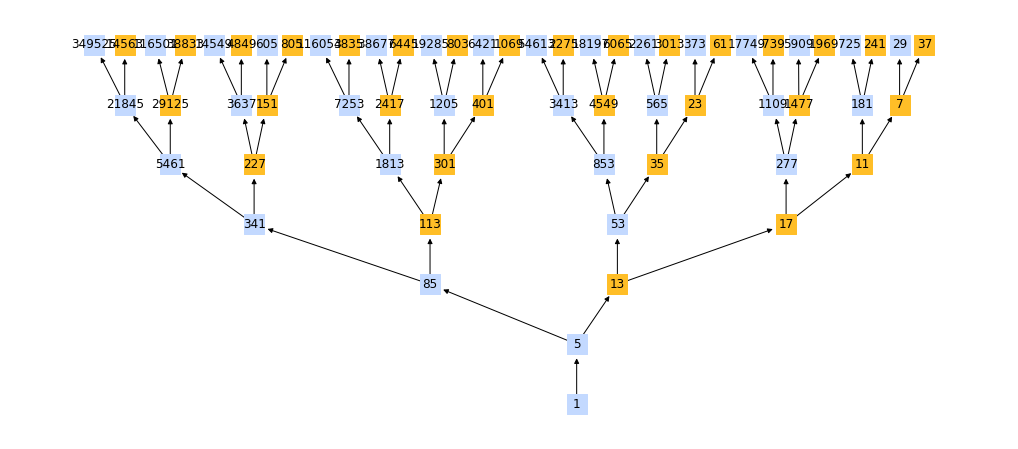

In [7]:
#Binary Tree T_0 as per definition of Kleinnijenhuis
class T0(Tree):
    def __init__(self, root: Node, height: int):
        self.height = height
        super().__init__(root)

    def generate(self, node: Node):
        if node.row < self.height:
            left_child = Node(rightwardFn(node.label), True)
            right_child = Node(upwardFn(node.label))
            node.addSuccessor(left_child)
            node.addSuccessor(right_child)
            self.generate(left_child)
            self.generate(right_child)

root = Node(1, True)
t0_tree = T0(root, 6)

df = DataFrameGenerator.generateDataFrame(t0_tree.root, True)
G = nx.from_pandas_edgelist(df, 'predecessorId', 'successorId', create_using=nx.DiGraph)
node_colors = []
for node in G:
    prunable = df.loc[(df.successorId == node), 'prunable']
    node_colors.append(Node.ORANGE) if prunable.count() > 0 and prunable.iloc[0] else node_colors.append(Node.BLUE)

pos = graphviz_layout(G, prog="dot", root=1, args='-Gsplines=true -Gsep=1 -Goverlap=false -Gorientation=10')
plt.figure(figsize=(18, 8))
plt.gca().invert_yaxis()
nx.draw(G, node_color=node_colors, pos=pos, with_labels=True,  node_shape="s", node_size=400, linewidths=1)

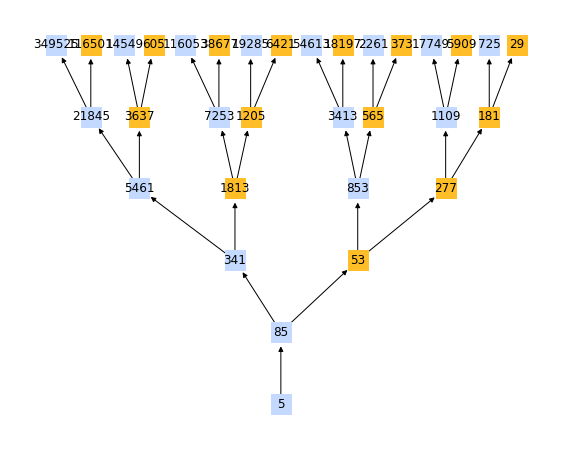

In [8]:
t1_tree = t0_tree.prune()

df = DataFrameGenerator.generateDataFrame(t1_tree.root, True)
G = nx.from_pandas_edgelist(df, 'predecessorId', 'successorId', create_using=nx.DiGraph)
node_colors = []
for node in G:
    prunable = df.loc[(df.successorId == node), 'prunable']
    node_colors.append(Node.ORANGE) if prunable.count() > 0 and prunable.iloc[0] else node_colors.append(Node.BLUE)

pos = graphviz_layout(G, prog="dot", root=1, args='-Gsplines=true -Gsep=1 -Goverlap=false -Gorientation=10')
plt.figure(figsize=(10, 8))
plt.gca().invert_yaxis()
nx.draw(G, node_color=node_colors, pos=pos, with_labels=True,  node_shape="s", node_size=400, linewidths=1)

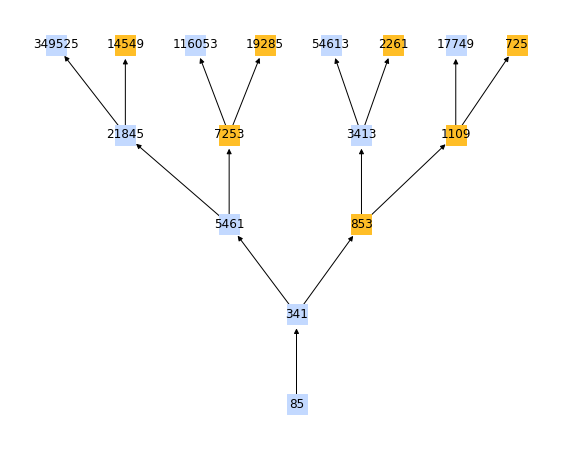

In [9]:
t2_tree = t1_tree.prune()

df = DataFrameGenerator.generateDataFrame(t2_tree.root, True)
G = nx.from_pandas_edgelist(df, 'predecessorId', 'successorId', create_using=nx.DiGraph)
node_colors = []
for node in G:
    prunable = df.loc[(df.successorId == node), 'prunable']
    node_colors.append(Node.ORANGE) if prunable.count() > 0 and prunable.iloc[0] else node_colors.append(Node.BLUE)

pos = graphviz_layout(G, prog="dot", root=1, args='-Gsplines=true -Gsep=1 -Goverlap=false -Gorientation=10')
plt.figure(figsize=(10, 8))
plt.gca().invert_yaxis()
nx.draw(G, node_color=node_colors, pos=pos, with_labels=True,  node_shape="s", node_size=400, linewidths=1)